In [1]:
!pip install deepface

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install deepface ultralytics faiss-cpu pandas

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable


In [4]:
"""
DeepFace: Framework Python untuk face recognition, face attribute analysis, dan fitur lain terkait wajah.
ultralytics: Pustaka untuk implementasi model YOLO (You Only Look Once), sering digunakan untuk object detection.
faiss-cpu: Library dari Facebook AI yang sangat efisien untuk similarity search, terutama pada data vektor tinggi (misalnya, digunakan dalam pencarian wajah).
pandas: Pustaka untuk manipulasi dan analisis data dalam bentuk tabel (DataFrame).
tf-keras: Keras adalah API untuk deep learning yang berjalan di atas TensorFlow (tf). Ini digunakan untuk membuat dan melatih model neural network.

"""

'\nDeepFace: Framework Python untuk face recognition, face attribute analysis, dan fitur lain terkait wajah.\nultralytics: Pustaka untuk implementasi model YOLO (You Only Look Once), sering digunakan untuk object detection.\nfaiss-cpu: Library dari Facebook AI yang sangat efisien untuk similarity search, terutama pada data vektor tinggi (misalnya, digunakan dalam pencarian wajah).\npandas: Pustaka untuk manipulasi dan analisis data dalam bentuk tabel (DataFrame).\ntf-keras: Keras adalah API untuk deep learning yang berjalan di atas TensorFlow (tf). Ini digunakan untuk membuat dan melatih model neural network.\n\n'

In [8]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import numpy as np
import faiss


In [9]:
model_name = "Facenet" 
detector_backend = "opencv"
num_dimensions = 128 # Facenet output

In [37]:
representations = []

# Inisialisasi DataFrame Pandas untuk menyimpan nama orang dan embedding
df = pd.DataFrame(columns=["name", "embedding"])

# Dictionary untuk mapping file_name ke nama orang
file_to_name = {
    "nola.png" : "Nola",
    "indah.png" : "Indah",
    "zeyad.png" : "Zeyad",
    "heydar.png" : "Heydar",
    "irsan.png" : "Irsan",
    "ica.png" : "Ica"
}

# Dictionary Jabatan
name_to_position = {
    "Nola" : "Direktur PT. Pertamina Hulu Rokan",
    "Indah" : "Direktur Utama PT. Elnusa",
    "Zeyad" : "Raja Arab",
    "Heydar" : "Walikota Yogyakarta",
    "Irsan" : "Bupati Sleman",
    "Ica" : "Engineering"

}

for r, d, files in os.walk("../Belajar-DeepFace/dataset"):
    for file in files:
        if ".png" in file:
            exact_file = f"{r}/{file}"
            objs = DeepFace.represent(
                img_path=exact_file,
                model_name=model_name,
                detector_backend=detector_backend
            )
            
            # Dapatkan nama orang dari dictionary
            name = file_to_name.get(file, "Unknown")  # Jika file tidak ada dalam dictionary, beri nama 'Unknown'
            posisi = name_to_position.get(name, "Unknown Position")
            
            for obj in objs:
                embedding = obj["embedding"]
                representations.append([file, embedding])
                
                # Buat DataFrame baru dari nama dan embedding yang dihasilkan
                new_row = pd.DataFrame({"name": [name], "embedding": [embedding], "posisi" : [posisi]})
                
                # Gabungkan DataFrame baru ke DataFrame utama menggunakan pd.concat()
                df = pd.concat([df, new_row], ignore_index=True)

In [38]:
# number of dimension
for obj in objs:
    print(len(obj["embedding"]))

128


In [39]:
print(df)

     name                                          embedding  \
0  Heydar  [0.9592138528823853, -0.8505821228027344, -1.0...   
1     Ica  [-0.49587276577949524, 0.09616623818874359, 0....   
2   Indah  [0.9161869287490845, 0.0950334370136261, -1.01...   
3   Irsan  [-1.56090247631073, 0.02148061990737915, -1.47...   
4    Nola  [0.08040325343608856, -1.2522971630096436, -1....   
5   Zeyad  [-0.8684813976287842, -1.0016041994094849, 2.9...   

                              posisi  
0                Walikota Yogyakarta  
1                        Engineering  
2          Direktur Utama PT. Elnusa  
3                      Bupati Sleman  
4  Direktur PT. Pertamina Hulu Rokan  
5                          Raja Arab  


In [40]:
# Konversi embedding ke numpy array untuk FAISS
embeddings = df['embedding'].tolist()  # Ambil embedding dari DataFrame
embeddings = np.array(embeddings, dtype="f")  # Konversi ke numpy array

In [41]:
# Inisialisasi FAISS
index = faiss.IndexFlatL2(num_dimensions)

In [42]:
# Tambahkan embedding ke FAISS
index.add(embeddings)

In [43]:
# Simpan DataFrame ke CSV jika diperlukan
df.to_csv("face_embeddings.csv", index=False)

In [44]:
print(f"deepface unit test items have {len(representations)} images")

deepface unit test items have 6 images


In [45]:
embeddings = []
for key, value in representations:
    embeddings.append(value)

In [46]:
# euclidean
tic = time.time()
index = faiss.IndexFlatL2(num_dimensions)
toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 0.0 seconds


In [47]:
tic = time.time()
index.add(np.array(embeddings, dtype = "f"))
toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

6 vectors stored in faiss intance in 0.0009989738464355469 seconds


In [51]:
target_path = "../Belajar-DeepFace/target/ica1.png"  #input 1 gambar

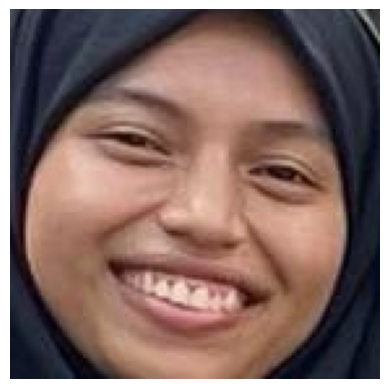

In [52]:
target_img = DeepFace.extract_faces(
    img_path = target_path, 
    detector_backend=detector_backend #next diubah menggunakan opencv
)[0]["face"]
plt.imshow(target_img)
plt.axis("off")
plt.show()

In [53]:
target_embedding = DeepFace.represent(
    img_path=target_path,
    model_name=model_name,
    detector_backend=detector_backend
)[0]["embedding"]

In [54]:
target_embedding = np.array(target_embedding, dtype = "f")

In [55]:
target_embedding = np.expand_dims(target_embedding, axis = 0)

In [56]:
target_embedding.shape

(1, 128)

In [60]:
# Lakukan pencarian di FAISS
k = 1  # Jumlah neighbor terdekat yang ingin dicari
tic = time.time()
distances, neighbours = index.search(target_embedding, k)
toc = time.time()
print(f"search completed in {toc - tic} in seconds")

search completed in 0.001997232437133789 in seconds


In [61]:
print(distances)

[[76.97211]]


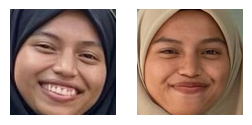

Nama: Ica
Jabatan: Engineering


In [62]:
# Cek neighbor dan tampilkan informasi dari Pandas
for idx, neighbour in enumerate(neighbours[0]):
    if neighbour < len(df):
        # Ambil nama dari DataFrame berdasarkan indeks neighbor
        neighbour_name = df.iloc[neighbour]['name']
        neighbour_position = df.iloc[neighbour]['posisi']
        neighbour_img_path = f"../Belajar-DeepFace/dataset/{representations[neighbour][0]}"  # Sesuaikan path gambar , #pakai folder di dataset
        
        # Ambil wajah neighbor dari gambar
        neighbour_img = DeepFace.extract_faces(
            img_path=neighbour_img_path,
            detector_backend=detector_backend
        )[0]["face"]
        
        # Visualisasi gambar target dan neighbor
        fig = plt.figure(figsize=(3, 3))
        fig.add_subplot(1, 2, 1)
        plt.imshow(target_img)
        plt.axis("off")
        fig.add_subplot(1, 2, 2)
        plt.imshow(neighbour_img)
        plt.axis("off")
        plt.show()
    else:
        print(f"Index {neighbour} out of range for DataFrame")

print(f"Nama: {neighbour_name}")
print(f"Jabatan: {neighbour_position}")